# Data → PCA → HJM

We use the USTreasury par yields and convert them to instantaneous forwards. The innovations Δf, PCA, reconstruction, vol shapes σᵢ(τ), HJM drift α(τ), and a one-path simulation are then followed.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pca_hjm_pipeline import HJMPipeline, demo_synthetic_par
print('Python ready.')

Python ready.


**Par yields** are coupon rates that make a coupon bond price to par; they are *averages* across many tiny future cashflows. In contrast, **instantaneous forwards** $f(\tau)$ are the *local* (marginal) rate for borrowing/lending over an infinitesimal period around maturity $\tau$. For modeling and trading:

1. $f(\tau)$ is the state variable in HJM; the no‐arbitrage drift $\alpha(\tau)$ and volatilities $\sigma_i(\tau)$ are defined directly on forwards.

2. PCA on changes in $f(\tau)$ isolates level/slope/curvature by maturity more cleanly than PCA on par yields (which mix tenors via coupons).

3. Signals like carry/roll and tenor-specific risk are naturally read off the *forward* curve, not the coupon‐averaged par curve.

In short: par yields blur information across maturities; forwards localize it and align with HJM’s dynamics.


The Excel file contains one worksheet per year (2016--2025), each with one year of daily U.S Treasury par yields at standard maturities. All sheets are downloaded, concatenated, sorted by date, duplicates removed, and rates kept in *decimals* (e.g.\ 3.5\% $\to$ 0.035).

For a fast approximation, 
let $y_{\text{par}}(\tau)$ be the par yield at maturity $\tau$. We form an approximate continuously–compounded zero rate
$$
r_c(\tau) \;\approx\; \ln\!\bigl(1 + y_{\text{par}}(\tau)\bigr)
$$
then its discount–accumulation
$$
z(\tau) \;=\; \tau\, r_c(\tau)
$$
and compute the instantaneous forward as the maturity–derivative
$$
f(\tau) \;=\; \frac{d z(\tau)}{d\tau}
$$
Operationally, we interpolate $z(\tau)$ to a quarter–year grid, take a numerical gradient, and sample $f(\tau)$ at integer years $1,2,\dots,30$. This is intentionally *fast* and sufficient for diagnostics; an exact bootstrap from par to zeros and forwards is a straightforward drop–in upgrade.

So if a par yield is $5\%$ (i.e., $y_{\text{par}}{=}0.05$) and the curve were locally flat,
$$
r_c \approx \ln(1{+}0.05) \approx 0.04879 \quad (\text{or } 4.879\%\ \text{per year}),
$$
so $z(\tau)=0.04879\,\tau$ and hence $f(\tau)=\frac{dz}{d\tau}\approx 0.04879$ for all $\tau$ under that flat assumption.  

A 5\% *par* rate roughly corresponds to a $4.88\%$ *instantaneous forward* if the curve is flat nearby. When the curve is not flat, $f(\tau)$ varies with $\tau$; our interpolation and gradient step captures that term-structure variation.

In [2]:
USE_EXCEL = True  # set True for your real data
excel_path = 'daily_UST.xlsx'  # update path
pipe = HJMPipeline(pca_top_k=3, poly_degree=3)

## 1) Load par yields

In [3]:
par_df = (pipe.load_par_yields_excel(excel_path, decimal=True, date_col='Date')
          if USE_EXCEL else demo_synthetic_par(n_days=700))
print('Loaded:', par_df.shape, 'maturities:', list(par_df.columns)[:10])
assert par_df.shape[1] > 0, 'No maturity columns—check headers and loader.'

Loaded: (2463, 14) maturities: [0.08333333333333333, 0.125, 0.16666666666666666, 0.25, 0.3333333333333333, 0.5, 1.0, 2.0, 3.0, 5.0]


## 2) Par → Forward (fast approx) + sanity checks

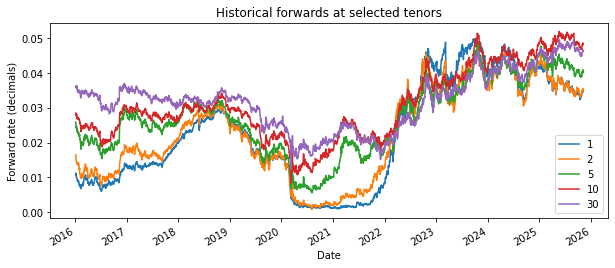

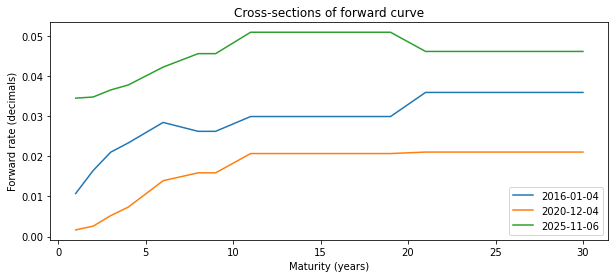

In [4]:
f_df = pipe.build_forward_panel()
pipe.plot_historicals(tenors=(1,2,5,10,30))
some_dates = [f_df.index[0], f_df.index[len(f_df)//2], f_df.index[-1]]
pipe.plot_cross_sections(some_dates)

## 3) Innovations Δf and PCA

We work with innovations $\Delta f_t(\tau)=f_t(\tau)-f_{t-1}(\tau)$ to suppress slow level drift and focus on co-movement of shocks.

1. Build the $T{\times}N$ matrix of $\Delta f$.

2. Column-center by removing each maturity's mean innovation.

3. Estimate covariance across maturities, annualize by $\times252$, eigen-decompose.

4. Sort eigenpairs; $v_i(\tau)$ unit-length loadings, $\lambda_i$ variances.

Empirically, PC1/PC2/PC3 $\approx$ level/slope/curvature.

In [5]:
innov = pipe.build_innovations()
run = pipe.run_pca()
print('Top-3 λ:', run.eigenvalues)
print('Explained ratio (Top-3):', run.explained_variance_ratio)

Top-3 λ: [0.00192317 0.00021115 0.0001365 ]
Explained ratio (Top-3): [0.80515177 0.08840141 0.05714506]


In time–series, an *innovation* is the *new, unpredictable component* $\varepsilon_t(\tau)$ that arrives between $t{-}1$ and $t$, the bit that cannot be forecast from the past. Iinnovation is the demeaned $\Delta f_t(\tau)$. A convenient way to see this is the decomposition
$$
\Delta f_t(\tau)\;=\; f_t(\tau)-f_{t-1}(\tau)
\;=\; \underbrace{\mathbb{E}\!\left[\Delta f_t(\tau)\mid \mathcal{F}_{t-1}\right]}_{\text{predictable drift}} 
\;+\; \underbrace{\varepsilon_t(\tau)}_{\text{innovation}}
$$
where $\mathcal{F}_{t-1}$ is the information up to $t{-}1$. After we *demean* across $t$ (column–center each $\tau$), the remaining variation in $\Delta f_t(\tau)$ is a good empirical proxy for the innovation $\varepsilon_t(\tau)$. In particular, we use innovations due to:

1. **Stationarity.** Differencing removes slow drifts/level shifts so the covariance of $\Delta f$ is more stable across time (better for PCA).

2. **Structure of shocks.** PCA on $\Delta f$ extracts the main co–movement directions of \emph{surprises} (level/slope/curvature shocks), not averages mixed by coupons.

3. **Link to HJM.** In continuous time, $df(t,\tau)=\alpha(\tau)\,dt+\sum_i \sigma_i(\tau)\,dW_i(t)$. Over one day, 
  $\Delta f_t(\tau)\approx \alpha(\tau)\Delta t+\sum_i \sigma_i(\tau)\,\Delta W_{i,t}$, so the \emph{unpredictable} part of $\Delta f_t$ identifies the volatility shapes $\sigma_i(\tau)$ we feed into HJM.


## 4) In-sample reconstruction (actual vs 3-PC)

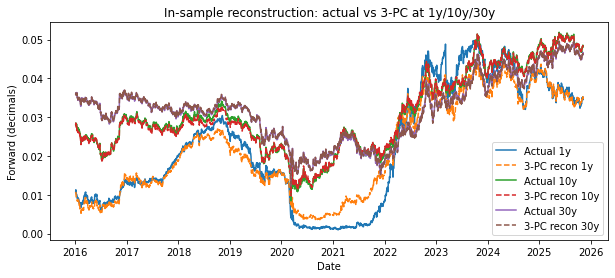

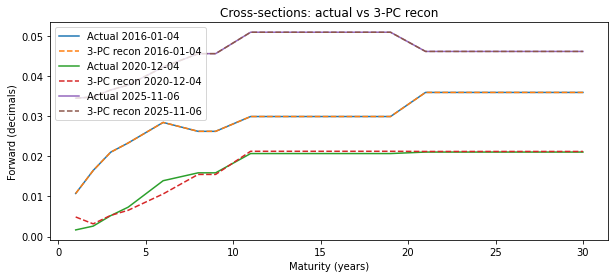

In [6]:
fhat = pipe.reconstruct_forwards(k=3)
mats = f_df.columns.values.astype(float)
sel = []
for T in (1,10,30):
    j = int(np.argmin(np.abs(mats - float(T))))
    sel.append(f_df.columns[j])
plt.figure(figsize=(10,4))
for c in sel:
    plt.plot(f_df.index, f_df[c].values, label=f'Actual {c}y')
    plt.plot(f_df.index, fhat[c].values, linestyle='--', label=f'3-PC recon {c}y')
plt.title('In-sample reconstruction: actual vs 3-PC at 1y/10y/30y')
plt.xlabel('Date'); plt.ylabel('Forward (decimals)'); plt.legend(); plt.show()
dates_cs = [f_df.index[0], f_df.index[len(f_df)//2], f_df.index[-1]]
plt.figure(figsize=(10,4))
for d in dates_cs:
    plt.plot(mats, f_df.loc[d].values, label=f'Actual {pd.to_datetime(d).date()}')
    plt.plot(mats, fhat.loc[d].values, linestyle='--', label=f'3-PC recon {pd.to_datetime(d).date()}')
plt.title('Cross-sections: actual vs 3-PC recon')
plt.xlabel('Maturity (years)'); plt.ylabel('Forward (decimals)'); plt.legend(); plt.show()

## 5) PCA loadings & discretized vols σᵢ(τ) and smooth fits

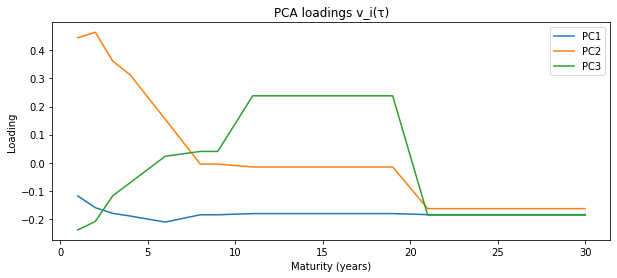

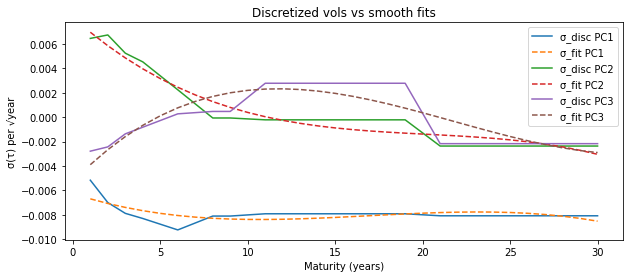

In [7]:
vols = pipe.compute_discretized_vols()
fits = pipe.fit_vols_polynomial()
pipe.plot_vols_and_fits()

The **Top Panel** shows PCA loadings $v_i(\tau)$ are the shapes of the main co-movements—PC1 $\approx$ level (mostly one sign), PC2 $\approx$ slope (short vs.\ long have opposite signs), PC3 $\approx$ curvature (belly vs.\ wings); and
\**Bottom Panel** the “Discretized vols” $\sigma_i(\tau)=\sqrt{\lambda_i}\,v_i(\tau)$ scale each shape by its typical size (per $\sqrt{\text{year}}$).
The top tells **where** each factor loads by maturity; the bottom tells **how hard** each factor typically hits those maturities. These $\sigma_i(\tau)$ are fed directly into HJM.

## 6) Vol map on 0–25y @ 0.5y

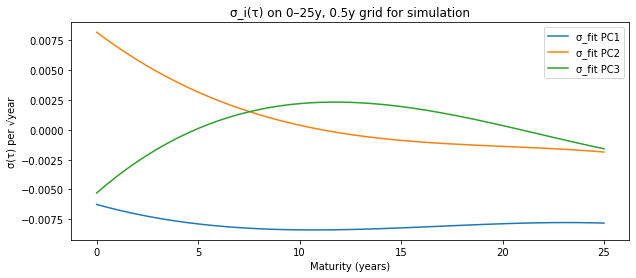

In [8]:
tau_grid = np.arange(0.0, 25.0 + 1e-9, 0.5)
sig_grid = pipe.eval_fitted_sigmas(tau_grid)
plt.figure(figsize=(10,4))
for j in range(sig_grid.shape[1]):
    plt.plot(tau_grid, sig_grid[:, j], label=f'σ_fit PC{j+1}')
plt.title('σ_i(τ) on 0–25y, 0.5y grid for MC simulation')
plt.xlabel('Maturity (years)'); plt.ylabel('σ(τ) per √year'); plt.legend(); plt.show()

The above plot shows the same fitted $\sigma_i(\tau)$ evaluated on a clean grid (0--25y every 0.5y). This is the “volatility map” the simulator uses.
A tidy grid avoids irregular spacing artifacts and makes the simulated curve’s evolution predictable across maturities.


## 7) HJM drift α(τ)

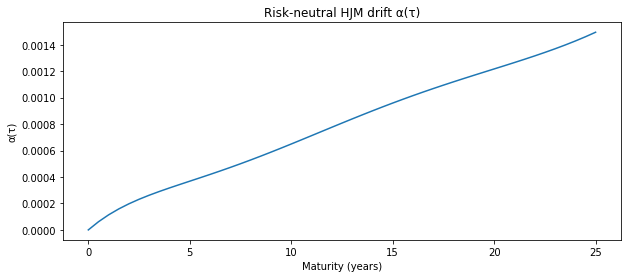

In [9]:
tau_eval, alpha = pipe.compute_alpha(tau_grid)
plt.figure(figsize=(10,4))
plt.plot(tau_eval, alpha)
plt.title('Risk-neutral HJM drift α(τ)')
plt.xlabel('Maturity (years)'); plt.ylabel('α(τ)'); plt.show()

The plot exhibits HJM no-arbitrage drift $\alpha(\tau)=\sum_i \sigma_i(\tau)\int_0^\tau \sigma_i(u)\,du$ implied by the fitted vol curves.
Even with no directional “view,” the forward curve has a systematic push that differs by maturity. The sign/size of $\alpha(\tau)$ helps explain model-implied carry/roll patterns.

## 8) Starting curve on sim grid

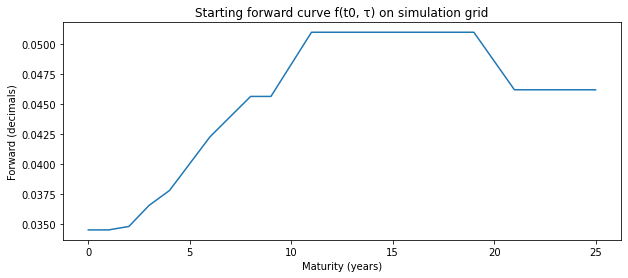

In [10]:
pipe.set_simulation_grid(0.0, 25.0, 0.5)
pipe.set_starting_forward()
plt.figure(figsize=(10,4))
plt.plot(pipe.sim_grid_tau, pipe.sim_start_forward)
plt.title('Starting forward curve f(t0, τ) on simulation grid')
plt.xlabel('Maturity (years)'); plt.ylabel('Forward (decimals)'); plt.show()

The plot shows the starting forward curve $f(t_0,\tau)$ on the same simulation grid.
This is the anchor for all paths. It’s also a quick unit/date sanity check: values that are too large/small or jagged often indicate data issues.


## 9) One HJM path: time-series + cross-sections

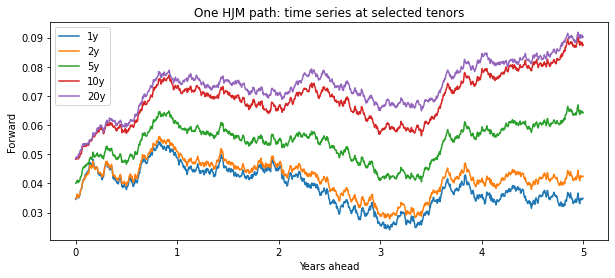

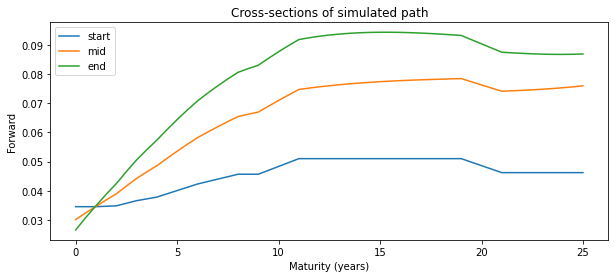

In [11]:
sim = pipe.simulate_hjm_path(years=5, steps_per_year=252, seed=7)
tau, f, dt = sim['tau'], sim['f'], sim['dt']
plt.figure(figsize=(10,4))
for T in (1,2,5,10,20):
    j = int(np.argmin(np.abs(tau - T)))
    plt.plot(np.arange(f.shape[0])*dt, f[:, j], label=f'{T}y')
plt.title('One HJM path: time series at selected tenors')
plt.xlabel('Years ahead'); plt.ylabel('Forward'); plt.legend(); plt.show()
plt.figure(figsize=(10,4))
for frac, lab in zip([0.0, 0.5, 1.0], ['start', 'mid', 'end']):
    row = f[int(frac*(f.shape[0]-1)), :]
    plt.plot(tau, row, label=lab)
plt.title('Cross-sections of simulated path')
plt.xlabel('Maturity (years)'); plt.ylabel('Forward'); plt.legend(); plt.show()

Finally, we observe an illustrative simulated HJM path, where the **Top Panel** exhibits time-series for a few tenors; and the **Bottom Panel** the cross-sections at start/mid/end (e.g 2025/2030/2035).
This turns the ingredients into dynamics. Differences across tenors reflect the level/slope/curvature mix in $\sigma_i(\tau)$ and the drift $\alpha(\tau)$, showing how the curve can steepen/flatten or gain/loss curvature over time.
